In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import split
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.affinity import scale
pd.set_option('display.max_columns', None)

In [2]:
imd = gpd.read_file("input/IMD2018.zip")
df = imd.cx[1747618.6612:1768514.9720,5909569.6924:5922316.0159]
df = df[df.dhb2015_na == "Auckland"].copy()
df.set_index("DZ2018", inplace=True)
df.sample(1)

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7600658,777,9,3,Auckland,1,Auckland Central,76,Auckland,2,Auckland Region,2207,4,2638.5,5,531,1,2631,5,2995,5,5276,9,260,1,635,2,2051,4,2890,5,2217,4,2160,4,1122,2,2577,5,2320,4,"POLYGON ((1754591.105 5920614.276, 1754599.170..."


<Axes: >

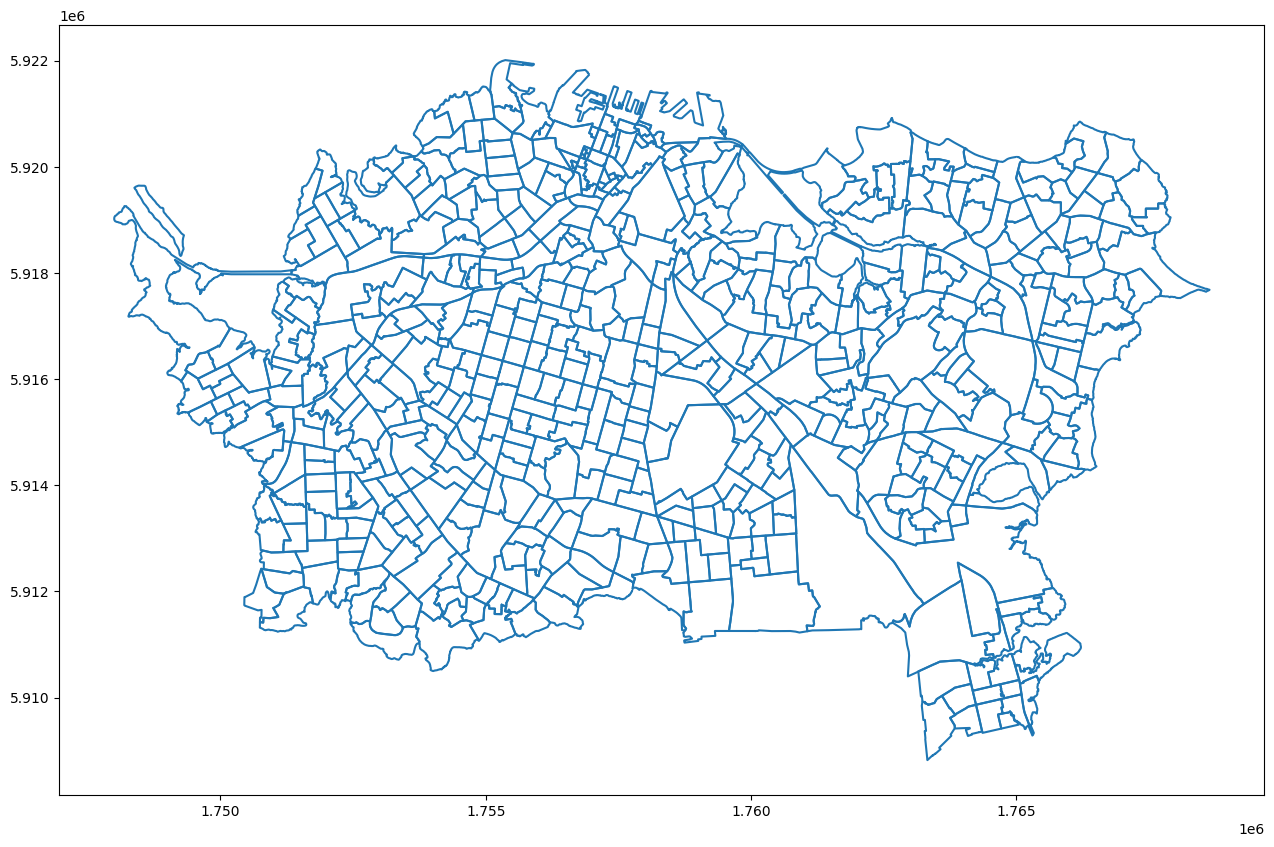

In [3]:
df.boundary.plot(figsize=(20,10))

Pull out one polygon to play with

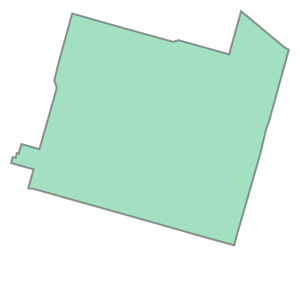

In [4]:
start = df.geometry.sample(1)
start_index = start.index[0]
start = start.iloc[0]
start

In [5]:
radius = start.centroid.distance(start.boundary)
radius

164.67817547673457

A hexagon is made of 6 equilateral triangles, with internal angles of 120 degrees. The internal angles of the equilateral triangles are all 60 degrees.

POLYGON ((1755969.3605926645 5917304.634625757, 1755887.021504926 5917447.250109169, 1755722.3433294492 5917447.250109169, 1755640.0042417108 5917304.634625757, 1755722.3433294492 5917162.0191423455, 1755887.021504926 5917162.0191423455, 1755969.3605926645 5917304.634625757))


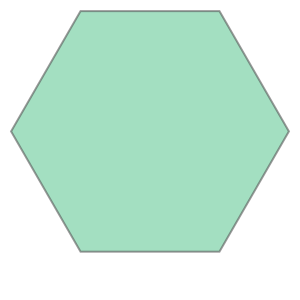

In [6]:
def create_hexagon(center, radius, rotate=False):
    """Create a hexagon centered at 'center' with a given 'radius', and include lines connecting each vertex to the center."""
    vertices = []
    for i in range(6):
        angle = math.radians(60 * i)  # Convert angle to radians
        if rotate:
            angle += math.radians(30)
        x = center.x + radius * math.cos(angle)  # X-coordinate
        y = center.y + radius * math.sin(angle)  # Y-coordinate
        vertices.append((x, y))  # Append vertex coordinates
    hexagon = Polygon(vertices)  # Create a polygon from the vertices
    return hexagon

start_hexagon = create_hexagon(start.centroid, radius)
assert start_hexagon.is_valid
print(start_hexagon)
start_hexagon

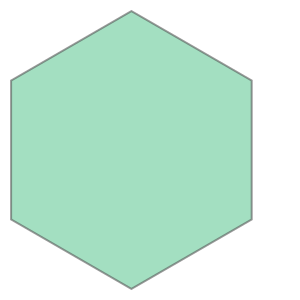

In [7]:
create_hexagon(start.centroid, radius, True)

In [8]:
df["hex_geo"] = gpd.GeoSeries()
df.loc[start_index, "hex_geo"] = start_hexagon

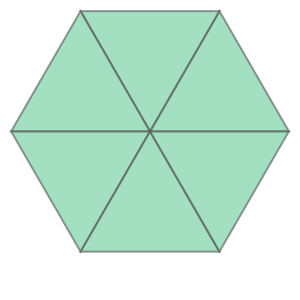

In [9]:
def hexagon_to_triangles(hexagon):
    center = hexagon.centroid
    vertices = list(hexagon.exterior.coords)
    triangles = []
    for i in range(6):
        next_i = (i + 1) % 6  # Wrap around to form a closed shape
        triangle = Polygon([center, vertices[i], vertices[next_i]])
        triangles.append(triangle)
    return GeometryCollection(triangles)

triangles = hexagon_to_triangles(start_hexagon)
assert triangles.is_valid
triangles

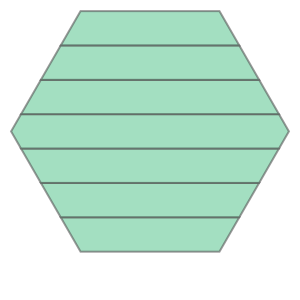

In [10]:
def slice_hexagon(hexagon, slices = 7):
  if hexagon is None:
    return None
  minx, miny, maxx, maxy = hexagon.bounds
  poly = hexagon
  segments = []
  slice_height = (maxy-miny) / slices
  for i in range(1, slices + 1):
    y = miny + slice_height * i
    parts = list(split(poly, LineString([(minx, y), (maxx, y)])).geoms)
    parts.sort(key=lambda p: p.bounds[1], reverse=True)
    #print(i, len(parts), [p.bounds[1] for p in parts], [p.area for p in parts])
    if len(parts) == 2:
      segments.append(parts[1])
      poly = parts[0]
    if i == slices:
      segments.append(parts[0])
  return GeometryCollection(segments)

slice_hexagon(start_hexagon)

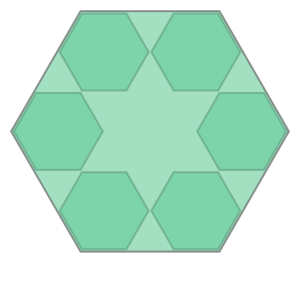

In [11]:
def sub_hexagons(hexagon):
    center = hexagon.centroid
    hexagons = []
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = start.centroid.x + radius * .66 * math.cos(angle)  # X-coordinate
        y = start.centroid.y + radius * .66 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .32))
    return GeometryCollection(hexagons)

GeometryCollection(list(sub_hexagons(start_hexagon).geoms) + [start_hexagon])

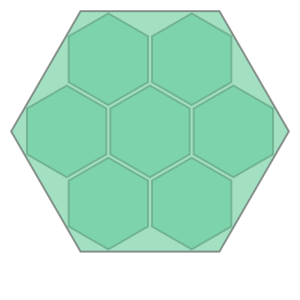

In [12]:
def sub_hexagons(hexagon):
    center = hexagon.centroid
    radius = start_hexagon.length / 6
    hexagons = [create_hexagon(center, radius * .33, True)]
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .6 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .6 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .33, True))
    return GeometryCollection(hexagons)

sub = sub_hexagons(start_hexagon)
GeometryCollection(list(sub.geoms) + [start_hexagon])

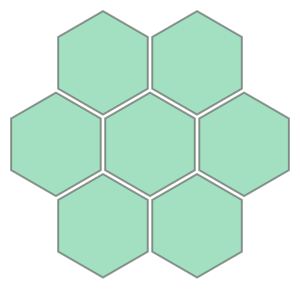

In [13]:
sub

<Axes: >

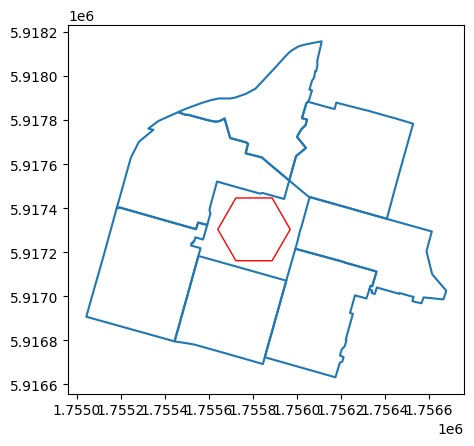

In [14]:
neighbours = df.geometry[df.touches(start)]
ax = neighbours.boundary.plot()
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

An equilateral triangle, split into two, makes two equal area triangles. The length of the line splitting the triangle, * 2, is the distance to the center of the neighbouring tesselated hexagon

142.61548341158777


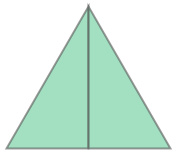

In [15]:
triangle = triangles.geoms[0]
v1, v2, v3 = set(triangle.exterior.coords)
midpoint = ((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
# Create a line from the midpoint to the opposite vertex
split_line = LineString([midpoint, v3])
print(split_line.length)
split_triangles = split(triangle, scale(split_line, yfact=1.001))
split_triangles

In [16]:
radius, split_line.length * 2

(164.67817547673457, 285.23096682317555)

<Axes: >

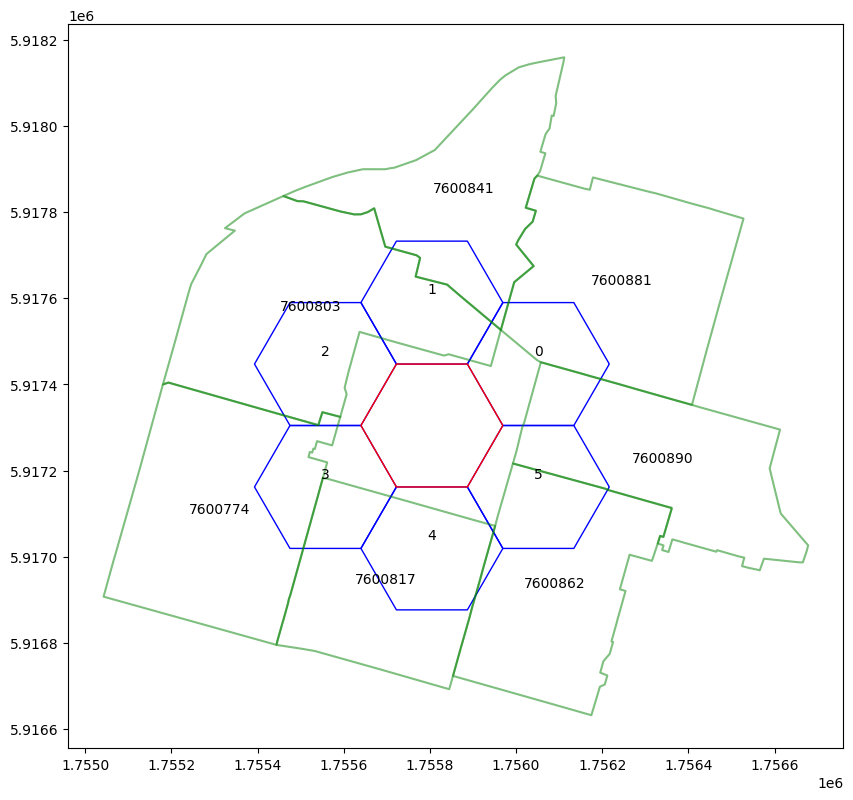

In [17]:
from shapely.geometry import Point
hex_neighbours = []
for i in range(6):
    angle = math.radians(60 * i + 30)  # Convert angle to radians
    x = start.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
    y = start.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
    hex_neighbours.append(create_hexagon(Point([x, y]), radius))

hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
ax = hex_neighbours.plot(edgecolor="blue", facecolor="none", figsize=(10,10))
for i in range(6):
  p = hex_neighbours.centroid.iloc[i]
  ax.annotate(text=str(i), xy=[p.x, p.y + radius / 8], ha='center')
neighbours.boundary.plot(ax=ax, color="green", alpha=.5)
for i in neighbours.index:
  ax.annotate(text=str(i), xy=[neighbours.centroid[i].x, neighbours.centroid[i].y], ha='center')
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

                  0           1           2           3           4  \
DZ2018                                                                
7600774  815.898808  693.368369  423.950190  252.267717  498.568121   
7600803  543.830918  282.882589  129.629215  411.478331  620.519078   
7600817  619.708894  660.270429  528.068962  264.270115  133.868475   
7600841  434.646380  265.947918  511.004285  754.792451  829.397869   
7600862  519.526182  719.754889  742.958354  581.194875  299.412484   
7600881  266.790868  441.603714  711.008304  831.994774  753.909033   
7600890  367.801373  651.439660  815.750564  785.766222  573.003294   

                  5  
DZ2018               
7600774  741.347491  
7600803  669.524272  
7600817  418.355087  
7600841  705.339451  
7600862  236.025043  
7600881  507.799038  
7600890  295.393673  


<Axes: ylabel='DZ2018'>

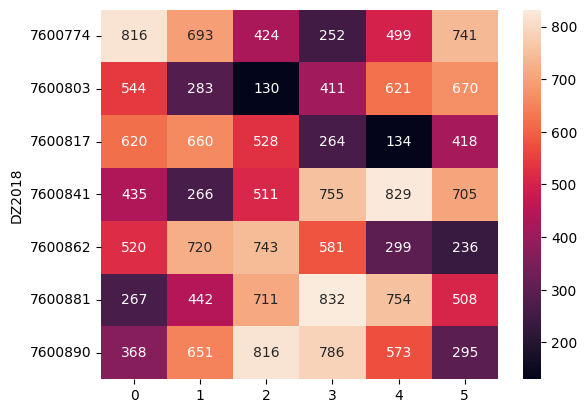

In [18]:
# Build a cost distance matrix
distance_matrix = neighbours.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
print(distance_matrix)
sns.heatmap(distance_matrix.round(), annot=True, fmt=".0f")

In [19]:
row_ind, col_ind = linear_sum_assignment(distance_matrix)
distance_matrix.index[row_ind], hex_neighbours[col_ind]
df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

In [20]:
for neighbour_index in neighbours.index:
  neighbour = neighbours[neighbour_index]
  neighbour_hex = df.hex_geo[neighbour_index]
  nn = df.geometry[df.hex_geo.isna() & df.touches(neighbour)]
  if len(nn) == 0:
     # No neighbours
     continue
  hex_neighbours = []
  for i in range(6):
      angle = math.radians(60 * i + 30)  # Convert angle to radians
      x = neighbour_hex.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
      y = neighbour_hex.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
      hex = create_hexagon(Point([x, y]), radius)
      # Filter out already used hexagons
      if df.hex_geo.centroid.distance(hex.centroid).min() > 1:
        hex_neighbours.append(hex)

  if len(hex_neighbours) == 0:
     # No available hexagons
     continue
  hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
  # Build a cost distance matrix
  distance_matrix = nn.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
  row_ind, col_ind = linear_sum_assignment(distance_matrix)
  distance_matrix.index[row_ind], hex_neighbours[col_ind]
  df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

In [21]:
df_hex = df[~df.hex_geo.isna()].copy()
df_hex.crs = df.crs
len(df_hex)

18

In [22]:
rank_cols = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi', 'Rank_Healt', 'Rank_Educa', 'Rank_Acces']

In [23]:
df_hex["sliced_hexagons"] = df_hex.hex_geo.apply(slice_hexagon)
df_hex["sub_hexagons"] = df_hex.hex_geo.apply(sub_hexagons)

<Axes: >

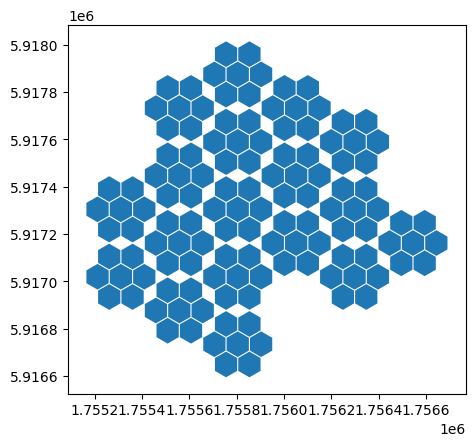

In [24]:
df_hex["sub_hexagons"].plot()

In [25]:
len(rank_cols), df_hex.sub_hexagons.apply(lambda g: len(g.geoms))

(7,
 DZ2018
 7600739    7
 7600754    7
 7600774    7
 7600785    7
 7600800    7
 7600803    7
 7600817    7
 7600829    7
 7600841    7
 7600845    7
 7600850    7
 7600862    7
 7600881    7
 7600889    7
 7600890    7
 7600893    7
 7600914    7
 7600930    7
 Name: sub_hexagons, dtype: int64)

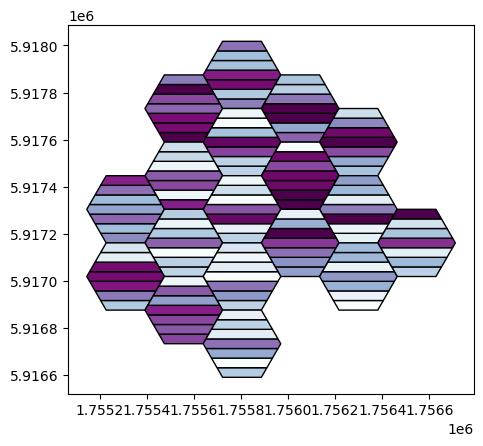

In [26]:
ax = plt.gca()
for i, rank_col in enumerate(rank_cols):
    df_hex.set_geometry(df_hex.sliced_hexagons.apply(lambda g: g.geoms[i])).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

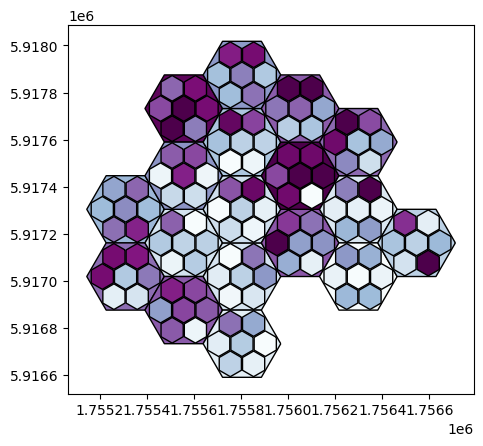

In [27]:
ax = plt.gca()
df_hex.set_geometry(df_hex.hex_geo).plot("Rank_IMD18", ax=ax, cmap="BuPu", edgecolor="black")
for i, rank_col in enumerate(rank_cols):
    df_hex.set_geometry(df_hex.sub_hexagons.apply(lambda g: g.geoms[i])).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")